# Integrating PySpark, Pandas, and SQL 

In [1]:
from pyspark.sql import SparkSession
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("PySpark_Pandas_SQL_Integration").getOrCreate()

In [3]:
df_spark = spark.read.csv("sales2_data.csv", header=True, inferSchema=True)

In [4]:
df_spark.show(5)

+-----------+-------------+--------------------+----------+---------------+-------------+-------+--------+----------+
|customer_id|customer_name|      customer_email|product_id|   product_name|product_price|sale_id|quantity| sale_date|
+-----------+-------------+--------------------+----------+---------------+-------------+-------+--------+----------+
|       1001|   John Smith|john.smith@email.com|      1234|T-Shirt (Large)|        19.99|  98765|       2|2024-05-14|
|       1002|     Jane Doe|  jane.doe@email.com|      4567|         Laptop|       899.99|  12345|       1|2024-05-13|
|       1003|  Michael Lee|michael.lee@email...|      7890|     Coffee Mug|         7.99|  54321|       3|2024-05-12|
|       1004|  Alice Jones|alice.jones@email...|      9871|     Headphones|        49.99|  78901|       2|2024-05-11|
|       1005|    David Lee| david.lee@email.com|      2345|          Mouse|        14.99|  34567|       1|2024-05-10|
+-----------+-------------+--------------------+--------

In [5]:
df_spark.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_email: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_price: double (nullable = true)
 |-- sale_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- sale_date: date (nullable = true)



### Clean

In [6]:
from pyspark.sql.functions import col, trim, lower

In [7]:
df_spark.count()

50

In [8]:
# Eliminate Nulls

cleaned_df = df_spark.filter(
    col("customer_id").isNotNull() &
    col("product_id").isNotNull() &
    col("product_price").isNotNull()
    )

cleaned_df.count()

50

In [9]:
# Eliminate duplicates

cleaned_df = cleaned_df.dropDuplicates(["sale_id"])
cleaned_df.count()

41

In [10]:
# There are no nulls in customer_id, product_id or product_price

df_spark.select(
    col("customer_id").isNull().alias("customer_id_null"),
    col("product_id").isNull().alias("product_id_null"),
    col("product_price").isNull().alias("product_price_null")
).groupBy("customer_id_null", "product_id_null", "product_price_null").count().show()

+----------------+---------------+------------------+-----+
|customer_id_null|product_id_null|product_price_null|count|
+----------------+---------------+------------------+-----+
|           false|          false|             false|   50|
+----------------+---------------+------------------+-----+



### Register the Cleaned DataFrame as a Temporary SQL Table

this will enable SQL queries

In [11]:
cleaned_df.createOrReplaceTempView("sales_table")

In [16]:
# Run an SQL query to calculate total sales revenue per product

sales_summary = spark.sql("""
    SELECT product_name, SUM(product_price * quantity) AS total_revenue
    FROM sales_table
    WHERE product_name LIKE 'Gaming%' OR product_name LIKE '%Desk%'
    GROUP BY product_name
    ORDER BY total_revenue DESC
    LIMIT 5
""")

# Display the result
sales_summary.show()

+--------------+-------------+
|  product_name|total_revenue|
+--------------+-------------+
|Gaming Headset|        99.99|
|  Gaming Mouse|        99.98|
|     Desk Lamp|        99.96|
|Desk Organizer|        59.96|
+--------------+-------------+



<Axes: xlabel='product_name'>

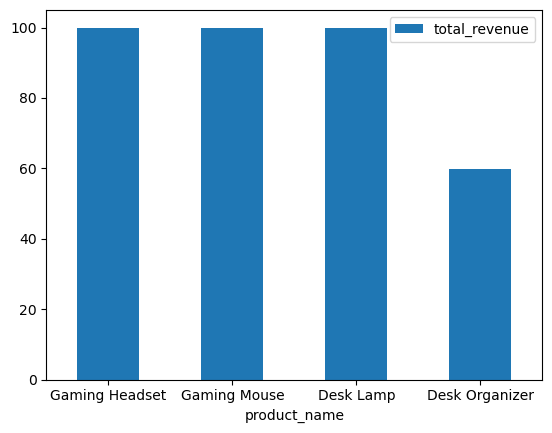

In [17]:
# Plot
sales_summary.toPandas().plot(x="product_name", y="total_revenue", kind="bar", rot=0)

### Identify top 3 Customer by total spending

In [23]:
# Run an SQL query to calculate total sales revenue per product

top_3_cust = spark.sql("""
    SELECT customer_name, SUM(product_price * quantity) AS total_revenue
    FROM sales_table    
    GROUP BY customer_name
    ORDER BY total_revenue DESC
    LIMIT 3
""")

# Display the result
top_3_cust.show()

+-------------+-------------+
|customer_name|total_revenue|
+-------------+-------------+
|     Jane Doe|       899.99|
|  Ryan Walker|       599.98|
|Sophia Taylor|       499.98|
+-------------+-------------+



### Average revenue per sale for each product.

In [25]:
sales_avg = spark.sql("""
    SELECT product_name, AVG(product_price * quantity) AS avg_revenue
    FROM sales_table    
    GROUP BY product_name
    ORDER BY avg_revenue DESC    
""")

# Display the result
sales_avg.show()

+-------------------+------------------+
|       product_name|       avg_revenue|
+-------------------+------------------+
|             Laptop|            899.99|
|        Camera Lens|           449.985|
|         Smartwatch|            399.98|
|             Tablet|           374.985|
|          Projector|            349.99|
|              Watch|           299.985|
|       Air Purifier|           194.985|
|Wireless Headphones|            149.98|
|           Backpack|           124.975|
|     Gaming Headset|             99.99|
|       Gaming Mouse|             99.98|
|         Headphones|             99.98|
|   Wireless Speaker|             79.99|
|    Fitness Tracker|            59.985|
|           Yoga Mat|            52.485|
|          Desk Lamp|             49.98|
|   Portable Charger|49.974999999999994|
|     Protein Powder|              49.9|
|    T-Shirt (Large)|             39.98|
|           Notebook|             39.96|
+-------------------+------------------+
only showing top

### Select the top 10 products based on average revenue per sale from the results above

In [35]:
top_10 = sales_avg.limit(10)
top_10.show()

+-------------------+-----------+
|       product_name|avg_revenue|
+-------------------+-----------+
|             Laptop|     899.99|
|        Camera Lens|    449.985|
|         Smartwatch|     399.98|
|             Tablet|    374.985|
|          Projector|     349.99|
|              Watch|    299.985|
|       Air Purifier|    194.985|
|Wireless Headphones|     149.98|
|           Backpack|    124.975|
|     Gaming Headset|      99.99|
+-------------------+-----------+



<Axes: xlabel='product_name'>

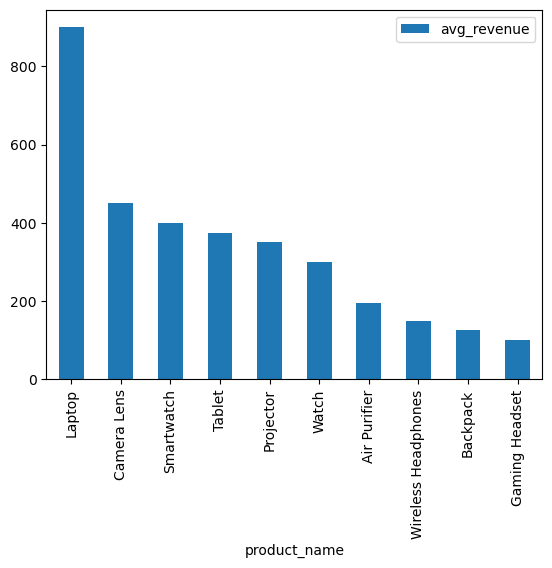

In [39]:
top_10.toPandas().plot(x="product_name", y="avg_revenue", kind="bar", rot=90)

In [45]:
popular_pro = spark.sql("""
    SELECT product_name, SUM(quantity) as tot
    FROM sales_table    
    GROUP BY product_name
    ORDER BY tot DESC 
    LIMIT 3
""")

popular_pro.show()

+----------------+---+
|    product_name|tot|
+----------------+---+
|      Travel Mug|  6|
|Portable Charger|  5|
|        Backpack|  5|
+----------------+---+



<Axes: xlabel='product_name'>

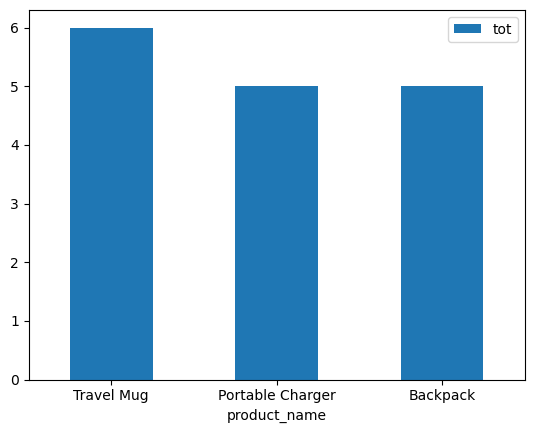

In [47]:
popular_pro.toPandas().plot(x="product_name", y="tot", kind="bar", rot=0)